In [1]:
import numpy as np
import torch
from torch import nn
from tropical import to_tensor, Tropical, TropicalMonomial, TropicalPolynomial, PolyNet, DiffPolyNet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import JuPyMake
JuPyMake.InitializePolymake()
JuPyMake.ExecuteCommand("application 'tropical';")

(True, '', '', '')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def to_tensor(x):
    return torch.tensor(x).float()

# Создаем сеть 2-18-2 со случайными весами

In [6]:
inp_size = [2,18]
out_size = [18,2]

t = Tropical(0)

# A = [np.random.randint(-10, 10, size=inp_size[i]*out_size[i]).reshape(out_size[i],inp_size[i]) for i in range(len(inp_size))]

# b = [np.random.randn(out_size[i]) for i in range(len(A))]

In [7]:
class Net(torch.nn.Module):
    def __init__(self, inp_size, out_size):
        super(Net, self).__init__()
        
        self.linears = nn.ModuleList([nn.Linear(inp_size[0], out_size[0])])
        
        for i in range(1, len(inp_size)):
            self.linears.extend([nn.Linear(inp_size[i], out_size[i])])
                
#         for i in range(len(inp_size)):
#             self.linears[i].weight.data.copy_(to_tensor(A[i]))
#             self.linears[i].bias.data.copy_(to_tensor(b[i]))
    def forward(self, output):
        for i, l in enumerate(self.linears):
            output = l.forward(output)
            if i<len(self.linears)-1:
                output = torch.relu(output)
        return output

# Создадим стандартную классификационную задачу

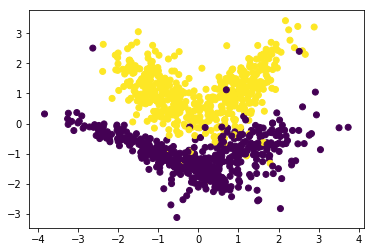

In [11]:
from sklearn.datasets import make_classification

X, Y = make_classification(n_samples=1000,n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, n_classes=2)


plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)   
x_t = torch.from_numpy(X).float()
y_t = torch.from_numpy(Y).long()

In [12]:
model = Net(inp_size,out_size)

epochs = 3000
batch_size = 100
criterion = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.0001)

dataset = torch.utils.data.TensorDataset(x_t, y_t)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


for epoch in range(epochs):
    loss_epoch = 0
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        loss_epoch += loss.item()
        
        opt.step()
        opt.zero_grad()
    
    if epoch%100 == 0:
        with torch.no_grad():
            acc = (model.forward(x_t).argmax(1)==y_t.flatten()).float().mean()
        print('Epoch: ', epoch, ' loss: ', loss_epoch, 'acc: ', acc)
        

    



Epoch:  0  loss:  7.237672924995422 acc:  tensor(0.5580)
Epoch:  100  loss:  6.76944625377655 acc:  tensor(0.5890)
Epoch:  200  loss:  6.370645582675934 acc:  tensor(0.6430)
Epoch:  300  loss:  6.024350166320801 acc:  tensor(0.7560)
Epoch:  400  loss:  5.718816816806793 acc:  tensor(0.8570)
Epoch:  500  loss:  5.445815205574036 acc:  tensor(0.8980)
Epoch:  600  loss:  5.199567556381226 acc:  tensor(0.9100)
Epoch:  700  loss:  4.975686997175217 acc:  tensor(0.9230)
Epoch:  800  loss:  4.770606249570847 acc:  tensor(0.9270)
Epoch:  900  loss:  4.58218377828598 acc:  tensor(0.9310)
Epoch:  1000  loss:  4.408209592103958 acc:  tensor(0.9320)
Epoch:  1100  loss:  4.24709352850914 acc:  tensor(0.9360)
Epoch:  1200  loss:  4.097312182188034 acc:  tensor(0.9390)
Epoch:  1300  loss:  3.958063244819641 acc:  tensor(0.9410)
Epoch:  1400  loss:  3.828412353992462 acc:  tensor(0.9430)
Epoch:  1500  loss:  3.7073892652988434 acc:  tensor(0.9480)
Epoch:  1600  loss:  3.5945460200309753 acc:  tensor(0

In [13]:
def convert_net_to_tropical(net):
    
    d = model.linears[0].in_features
    f = [TropicalPolynomial([[0]+np.eye(d)[i].tolist()]) for i in range(d)]
    
    g = [TropicalPolynomial([[0]+np.zeros(d).tolist()]) for i in range(d)]


    for l in model.linears:
        
        n = l.in_features
        m = l.out_features
        a = l.weight.data.detach().cpu().numpy()
        a_plus = np.maximum(a,0)
        a_minus = np.maximum(-a,0)
        b_ = l.bias.data.detach().cpu().numpy()
        
        new_g = []
        new_h = []
        new_f = []
        
        for i in range(m):
            g_i = None
            h_i = None
            f_i = None
            for j in range(n):
                if g_i is None:
                    g_i = f[j]**a_minus[i][j]
                    g_i *= g[j]**a_plus[i][j]
                else:
                    g_i *= f[j]**a_minus[i][j]
                    g_i *= g[j]**a_plus[i][j]
                
                if h_i is None:
                    h_i = f[j]**a_plus[i][j]
                    h_i *= g[j]**a_minus[i][j]
                else:
                    h_i *= f[j]**a_plus[i][j]
                    h_i *= g[j]**a_minus[i][j]
                
            h_i *= Tropical(b_[i])
            f_i = h_i+g_i*t
            
            new_g.append(g_i)
            new_h.append(h_i)
            new_f.append(f_i)
        
        f = new_f
        g = new_g
        h = new_h

        
    return f,g,h
        

# Домножим веса на 10 и округлим до int

In [14]:
model.linears[0].weight.data.copy_((model.linears[0].weight*10).int())
model.linears[1].weight.data.copy_((model.linears[1].weight*10).int())

model.linears[0].bias.data.copy_((model.linears[0].bias*10).int())
model.linears[1].bias.data.copy_((model.linears[1].bias*10).int())

print('New acc: ', (model.forward(x).argmax(1)==y.flatten()).float().mean())

New acc:  tensor(0.9700)


# Конвертим в разницу полиномов

In [15]:
f,g,h = convert_net_to_tropical(model)

In [16]:
h[0]

5.0⨀a^27⨀b^10 ⨁ 9.0⨀a^37⨀b^10 ⨁ a^23⨀b^30 ⨁ 4.0⨀a^33⨀b^30 ⨁ 4.0⨀a^11 ⨁ 5.0⨀a^14⨀b^11 ⨁ 9.0⨀a^24⨀b^11 ⨁ 8.0⨀a^21 ⨁ a^10⨀b^31 ⨁ 4.0⨀a^20⨀b^31 ⨁ 1.0⨀a^26⨀b^41 ⨁ 5.0⨀a^36⨀b^41 ⨁ 4.0⨀a^22⨀b^13 ⨁ 8.0⨀a^32⨀b^13 ⨁ a^11⨀b^24 ⨁ 4.0⨀a^21⨀b^24 ⨁ 1.0⨀a^27⨀b^34 ⨁ 5.0⨀a^37⨀b^34 ⨁ 5.0⨀a^15⨀b^4 ⨁ 9.0⨀a^25⨀b^4 ⨁ 1.0⨀a^14⨀b^35 ⨁ 5.0⨀a^24⨀b^35 ⨁ 4.0⨀a^23⨀b^6 ⨁ 8.0⨀a^33⨀b^6 ⨁ 5.0⨀a^26⨀b^17 ⨁ 9.0⨀a^36⨀b^17 ⨁ a^22⨀b^37 ⨁ 4.0⨀a^32⨀b^37 ⨁ 4.0⨀a^10⨀b^7 ⨁ 8.0⨀a^20⨀b^7 ⨁ 1.0⨀a^15⨀b^28 ⨁ 5.0⨀a^25⨀b^28

In [17]:
h[0].minimize()

9.0⨀a^37⨀b^10 ⨁ 4.0⨀a^11 ⨁ 5.0⨀a^14⨀b^11 ⨁ 9.0⨀a^24⨀b^11 ⨁ 8.0⨀a^21 ⨁ a^10⨀b^31 ⨁ 1.0⨀a^26⨀b^41 ⨁ 5.0⨀a^36⨀b^41 ⨁ 5.0⨀a^37⨀b^34 ⨁ 9.0⨀a^25⨀b^4 ⨁ 1.0⨀a^14⨀b^35 ⨁ 5.0⨀a^24⨀b^35 ⨁ 8.0⨀a^33⨀b^6 ⨁ 9.0⨀a^36⨀b^17 ⨁ 4.0⨀a^10⨀b^7 ⨁ 8.0⨀a^20⨀b^7

In [18]:
g[0]

13.0⨀a^31⨀b^70 ⨁ 14.0⨀a^35⨀b^70 ⨁ 29.0⨀a^31⨀b^80 ⨁ 18.0⨀a^41⨀b^80 ⨁ 30.0⨀a^35⨀b^80 ⨁ 19.0⨀a^45⨀b^80 ⨁ -1.0⨀a^22⨀b^41 ⨁ a^26⨀b^41 ⨁ 14.0⨀a^21⨀b^51 ⨁ 13.0⨀a^17⨀b^51 ⨁ 25.0⨀a^22⨀b^61 ⨁ 26.0⨀a^26⨀b^61 ⨁ 2.0⨀a^34⨀b^62 ⨁ 3.0⨀a^38⨀b^62 ⨁ 17.0⨀a^33⨀b^72 ⨁ 16.0⨀a^29⨀b^72 ⨁ 28.0⨀a^34⨀b^82 ⨁ 29.0⨀a^38⨀b^82 ⨁ -2.0⨀a^25⨀b^43 ⨁ -1.0⨀a^29⨀b^43 ⨁ 12.0⨀a^20⨀b^53 ⨁ 13.0⨀a^24⨀b^53 ⨁ 14.0⨀a^25⨀b^53 ⨁ 15.0⨀a^29⨀b^53 ⨁ 28.0⨀a^20⨀b^63 ⨁ 29.0⨀a^24⨀b^63 ⨁ 2.0⨀a^41⨀b^64 ⨁ 1.0⨀a^37⨀b^64 ⨁ 18.0⨀a^41⨀b^74 ⨁ 15.0⨀a^32⨀b^74 ⨁ 16.0⨀a^36⨀b^74 ⨁ 17.0⨀a^37⨀b^74 ⨁ 31.0⨀a^32⨀b^84 ⨁ 32.0⨀a^36⨀b^84 ⨁ 1.0⨀a^23⨀b^45 ⨁ 2.0⨀a^27⨀b^45 ⨁ 14.0⨀a^32⨀b^55 ⨁ 13.0⨀a^28⨀b^55 ⨁ 27.0⨀a^23⨀b^65 ⨁ 28.0⨀a^27⨀b^65 ⨁ 4.0⨀a^35⨀b^66 ⨁ 5.0⨀a^39⨀b^66 ⨁ 16.0⨀a^40⨀b^76 ⨁ 17.0⨀a^44⨀b^76 ⨁ 30.0⨀a^35⨀b^86 ⨁ 31.0⨀a^39⨀b^86 ⨁ 12.0⨀a^20⨀b^47 ⨁ 1.0⨀a^30⨀b^47 ⨁ 11.0⨀a^16⨀b^47 ⨁ a^26⨀b^47 ⨁ 17.0⨀a^30⨀b^57 ⨁ 16.0⨀a^26⨀b^57 ⨁ 15.0⨀a^32⨀b^68 ⨁ 4.0⨀a^42⨀b^68 ⨁ 14.0⨀a^28⨀b^68 ⨁ 3.0⨀a^38⨀b^68 ⨁ 20.0⨀a^42⨀b^78 ⨁ 19.0⨀a^38⨀b^78 ⨁ 11.0⨀a^23⨀b^49 ⨁ 10.0⨀a^19⨀b^49 ⨁ 2

In [19]:
g[0].minimize()

19.0⨀a^45⨀b^80 ⨁ -1.0⨀a^22⨀b^41 ⨁ a^26⨀b^41 ⨁ 26.0⨀a^26⨀b^61 ⨁ 29.0⨀a^38⨀b^82 ⨁ -1.0⨀a^29⨀b^43 ⨁ 15.0⨀a^29⨀b^53 ⨁ 28.0⨀a^20⨀b^63 ⨁ 29.0⨀a^24⨀b^63 ⨁ 2.0⨀a^41⨀b^64 ⨁ 31.0⨀a^32⨀b^84 ⨁ 32.0⨀a^36⨀b^84 ⨁ 14.0⨀a^32⨀b^55 ⨁ 28.0⨀a^27⨀b^65 ⨁ 17.0⨀a^44⨀b^76 ⨁ 30.0⨀a^35⨀b^86 ⨁ 31.0⨀a^39⨀b^86 ⨁ 12.0⨀a^20⨀b^47 ⨁ 11.0⨀a^16⨀b^47 ⨁ 27.0⨀a^23⨀b^59 ⨁ 26.0⨀a^19⨀b^59

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по первой координате

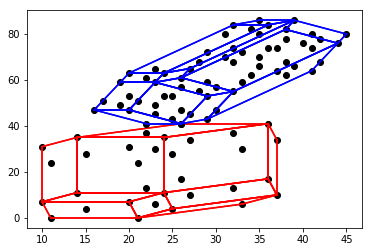

In [21]:
h[0].plot_dual_sub(color='red',name='b')

g[0].plot_dual_sub(color='blue',name='b')

# Полигоны Ньютона и subdivision для каждого из полиномов разницы по второй координате

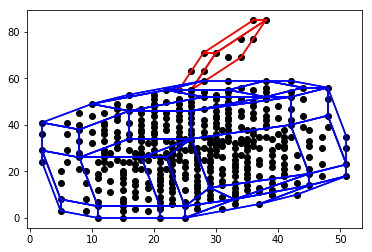

In [22]:
h[1].plot_dual_sub(color='red',name='b')

g[1].plot_dual_sub(color='blue',name='b')

In [23]:
h0_min = h[0].minimize()
h1_min = h[1].minimize()
g0_min = g[0].minimize()
g1_min = g[1].minimize()

# Составляем полином из статьи

In [24]:
R = h0_min*g1_min + h1_min*g0_min

In [27]:
R_min = R.minimize()

In [28]:
R_min

2.0⨀a^15⨀b^10 ⨁ 15.0⨀a^80⨀b^20 ⨁ 18.0⨀a^78⨀b^20 ⨁ -1.0⨀a^12⨀b^60 ⨁ 2.0⨀a^12⨀b^31 ⨁ 48.0⨀a^71⨀b^171 ⨁ 49.0⨀a^75⨀b^171 ⨁ 48.0⨀a^77⨀b^171 ⨁ 16.0⨀a^70⨀b^12 ⨁ 8.0⨀a^21⨀b^12 ⨁ 19.0⨀a^58⨀b^12 ⨁ 7.0⨀a^22 ⨁ 11.0⨀a^32 ⨁ 15.0⨀a^42 ⨁ -3.0⨀a^12⨀b^72 ⨁ 8.0⨀a^18⨀b^33 ⨁ 18.0⨀a^88⨀b^33 ⨁ 2.0⨀a^16⨀b^3 ⨁ 19.0⨀a^82⨀b^24 ⨁ 2.0⨀a^13⨀b^24 ⨁ 16.0⨀a^84⨀b^24 ⨁ 45.0⨀a^52⨀b^134 ⨁ 44.0⨀a^48⨀b^134 ⨁ 17.0⨀a^50⨀b^4 ⨁ 3.0⨀a^15⨀b^15 ⨁ 16.0⨀a^88⨀b^45 ⨁ 47.0⨀a^60⨀b^155 ⨁ 48.0⨀a^64⨀b^155 ⨁ 36.0⨀a^83⨀b^165 ⨁ 8.0⨀a^22⨀b^5 ⨁ 12.0⨀a^32⨀b^5 ⨁ 16.0⨀a^42⨀b^5 ⨁ 17.0⨀a^74⨀b^16 ⨁ 14.0⨀a^76⨀b^16 ⨁ 8.0⨀a^19⨀b^26 ⨁ 3.0⨀a^12⨀b^36 ⨁ 16.0⨀a^46 ⨁ 16.0⨀a^58⨀b^6 ⨁ 14.0⨀a^88⨀b^57 ⨁ 19.0⨀a^70⨀b^18 ⨁ 17.0⨀a^88⨀b^28 ⨁ 47.0⨀a^60⨀b^148 ⨁ 46.0⨀a^56⨀b^148 ⨁ 1.0⨀a^12⨀b^48 ⨁ 18.0⨀a^54⨀b^8 ⨁ 3.0⨀a^16⨀b^8 ⨁ 20.0⨀a^82⨀b^29 ⨁ 3.0⨀a^13⨀b^29 ⨁ 50.0⨀a^72⨀b^169 ⨁ 49.0⨀a^68⨀b^169 ⨁ 12.0⨀a^88⨀b^69

# Полигоны Ньютона и subdivision для нового полинома и двух его слагаемых

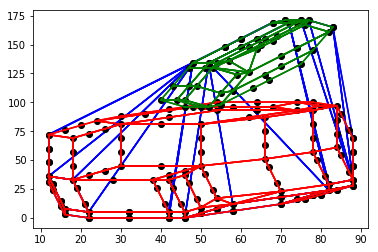

In [29]:
R_min.plot_dual_sub(color='blue',name='b')
(h0_min*g1_min).minimize().plot_dual_sub(color='red',name='b')
(h1_min*g0_min).minimize().plot_dual_sub(color='green',name='b')

# Рисуем реальную decision boundary исходной нейронки

In [30]:
def plot_decision_boundary(pred_func):
    xx,yy = np.meshgrid(np.arange(-5000, 5000, 1), np.arange(-5000, 5000, 1))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

In [31]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.forward(x)
    return ans.argmax(1).float().numpy()

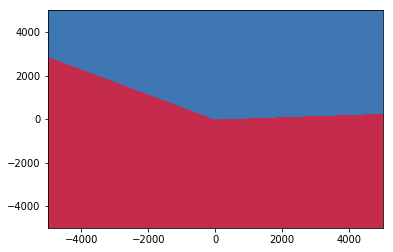

In [32]:
plot_decision_boundary(lambda x : predict(x))

# Видно, что decision boundary перпендикулярны тем границам полигона Нюьтона, которые не покрыты полигонами слагаемых.